# Семантическая сегментация

In [1]:
import torch

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam, AdamW

from torchvision.datasets import ImageFolder
import torchvision.transforms.v2 as tt
import torchinfo

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image

from tqdm.auto import tqdm
from IPython.display import clear_output

/home/daiyousei/.conda/envs/ds311/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/daiyousei/.conda/envs/ds311/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit an

In [2]:
from accelerate import Accelerator

In [3]:
accelerator = Accelerator()
DEVICE = accelerator.device
print("The notebook will be running on", DEVICE, "device")

The notebook will be running on cuda device


In [4]:
RANDOM_STATE = 177013
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)

IMAGE_SIZE = 128
BATCH_SIZE = 32
LATENT_SIZE = 128

torch.backends.cudnn.benchmark = True

In [5]:
transformations = tt.Compose(
    [
        tt.Resize(IMAGE_SIZE),
        tt.CenterCrop(IMAGE_SIZE),
        tt.ToImageTensor(),
        tt.ConvertDtype(),
        tt.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
)

In [6]:
target_transformations = tt.Compose(
    [
        tt.Resize(IMAGE_SIZE, interpolation=tt.InterpolationMode.NEAREST),
        tt.CenterCrop(IMAGE_SIZE),
        tt.ToImageTensor(),
        tt.ConvertDtype(),
        #tt.ToDtype(torch.long),
    ]
)

## Реализация датасета для набора "изображение - разметка"

In [7]:
class TwoFolderDataset(Dataset):        
    def __init__(self, root):
        self.root = Path(root)
        self.img_list = []
        for file in (self.root / 'Images').iterdir():
            if file.is_file():
                self.img_list.append(file.name)
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        filename = self.img_list[index]
        img_path = self.root / 'Images' / filename
        mask_path = self.root / 'Labels' / ('annotated_' + filename)
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        
        img = transformations(img)
        mask = target_transformations(mask)
            
        return img, mask

In [8]:
dataset = TwoFolderDataset('Dog Segmentation')

In [9]:
generator = torch.Generator().manual_seed(177013)
train_set, test_set = random_split(dataset, [0.7, 0.3], generator=generator)

In [10]:
train_dl = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=12, pin_memory=True)
test_dl = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=12, pin_memory=True)

## Архитектура UNet

In [11]:
class UNet(nn.Module):
    def conv_block(self, in_channels, out_channels, kernel_size, padding, activation=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
        ]
        if activation:
            layers.append(nn.ReLU())
        
        return nn.Sequential(*layers)
        
    def __init__(self, n_features=128):
        super().__init__()
        self.enc_conv0 = self.conv_block(3, n_features, 3, 1)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv1 = self.conv_block(n_features, n_features*2, 3, 1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv2 = self.conv_block(n_features*2, n_features*4, 3, 1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv3 = self.conv_block(n_features*4, n_features*8, 3, 1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(n_features*8, n_features*16, kernel_size=1, padding=0),
            nn.BatchNorm2d(n_features*16),
            nn.Conv2d(n_features*16, n_features*16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(n_features*16),
            nn.Conv2d(n_features*16, n_features*8, kernel_size=1, padding=0),
            nn.BatchNorm2d(n_features*8),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv0 = self.conv_block(n_features*16, n_features*4, 3, 1)
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv1 = self.conv_block(n_features*8, n_features*2, 3, 1)
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv2 = self.conv_block(n_features*4, n_features, 3, 1)
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv3 = self.conv_block(n_features*2, 1, 3, 1, activation=False)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0, idx0 = self.pool0(e0)
        e1 = self.enc_conv1(p0)
        p1, idx1 = self.pool1(e1)
        e2 = self.enc_conv2(p1)
        p2, idx2 = self.pool2(e2)
        e3 = self.enc_conv3(p2)
        p3, idx3 = self.pool3(e3)
        # bottleneck
        b = self.bottleneck_conv(p3)
        # decoder
        d0 = self.dec_conv0(torch.cat([self.upsample0(b, idx3), e3], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0, idx2), e2], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1, idx1), e1], 1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2, idx0), e0], 1))
        return torch.sigmoid(d3)

In [12]:
torchinfo.summary(UNet(), input_size=(1, 3, 128, 128))

/home/daiyousei/.conda/envs/ds311/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 128, 128]          --
├─Sequential: 1-1                        [1, 128, 128, 128]        --
│    └─Conv2d: 2-1                       [1, 128, 128, 128]        3,584
│    └─BatchNorm2d: 2-2                  [1, 128, 128, 128]        256
│    └─ReLU: 2-3                         [1, 128, 128, 128]        --
│    └─Conv2d: 2-4                       [1, 128, 128, 128]        147,584
│    └─BatchNorm2d: 2-5                  [1, 128, 128, 128]        256
│    └─ReLU: 2-6                         [1, 128, 128, 128]        --
├─MaxPool2d: 1-2                         [1, 128, 64, 64]          --
├─Sequential: 1-3                        [1, 256, 64, 64]          --
│    └─Conv2d: 2-7                       [1, 256, 64, 64]          295,168
│    └─BatchNorm2d: 2-8                  [1, 256, 64, 64]          512
│    └─ReLU: 2-9                         [1, 256, 64, 64]          --

In [13]:
model = UNet(LATENT_SIZE)
optim = AdamW(model.parameters(), lr=3e-4, weight_decay=5e-6)

In [14]:
model, optim, train_dl, test_dl = accelerator.prepare(model, optim, train_dl, test_dl)

In [15]:
batch_pic = lambda x: np.transpose(x.cpu().numpy(), (1, 2, 0))

## Метрика IoU

In [16]:
def iou_pytorch(outputs, labels):
    outputs = (outputs > 0.5).byte()
    labels = labels.byte() 
    epsilon = torch.finfo(torch.float32).eps
    intersection = (outputs & labels).float().sum((2, 3))
    union = (outputs | labels).float().sum((2, 3))
    
    iou = ((intersection + epsilon) / (union + epsilon)).mean(dim=1)
    
    return iou

## Функции потерь для сегментации

- Dice coefficient;
- focal loss;
- Tversky loss;
- boundary loss.

https://github.com/LIVIAETS/boundary-loss/blob/master/losses.py

In [17]:
def focal_loss(y_pred, y_real, eps=torch.finfo(torch.float32).eps, gamma=0):
    output = torch.clamp(y_pred, min=eps, max=1-eps)
    return torch.mean(-((1 - output) ** gamma * y_real * torch.log(output) + (1 - y_real) * torch.log(1 - output)))

In [18]:
def dice_loss(y_pred, y_real, squared=False):
    eps = torch.finfo(torch.float32).eps
    
    # Сумма произведений вдоль батча:
    num = 2 * torch.einsum("bcwh,bcwh->bc", y_pred, y_real) + eps
    # Сумма вдоль батча:
    den =  torch.einsum("bcwh->bc", torch.square(y_pred) if squared else y_pred) + torch.einsum("bcwh->bc", torch.square(y_real) if squared else y_real) + eps
    res = 1 -  (num / den)
    
    return torch.mean(res)

In [19]:
from scipy.ndimage import distance_transform_edt

def seg2dist(seg):
    res = np.zeros_like(seg.cpu().detach().numpy())
    for k in range(len(seg)):
        posmask = seg[k].cpu().numpy().astype('bool')
        if posmask.any():
            negmask = ~posmask
            # Тут небольшой хак: с одним классом модель будет склонна чуть преувеличивать размер
            # сегмента, так что за выход за его границы штрафуем с хорошим биасом:
            res[k] = (distance_transform_edt(negmask) + 1000) * negmask - (distance_transform_edt(posmask) - 1) * posmask
    return torch.from_numpy(res)

In [20]:
def boundary_loss(y_pred, y_real):
    dc = seg2dist(y_real).to(DEVICE)
    # Адамарово произведение:
    res = torch.einsum("bcwh,bcwh->bcwh", y_pred, dc)
    return res.mean() / 1000

In [21]:
def tversky_loss(y_pred, y_true, alpha=0.5, beta=0.5, smooth=torch.finfo(torch.float32).eps):
    tp = torch.sum(y_true * y_pred)
    fp = torch.sum((1 - y_true) * y_pred)
    fn = torch.sum(y_true * (1 - y_pred))
    
    tversky_coeff = (tp + smooth) / (tp + alpha * fp + beta * fn + smooth)
   
    return 1 - tversky_coeff

In [22]:
train_loss = []
test_loss = []
iou = []

In [23]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, metric=iou_pytorch):
    train_loss = []
    test_loss = []
    iou = []
    best_score = 0
    for epoch in range(epochs):
        avg_loss = 0
        model.train()
        for X_batch, Y_batch in tqdm(data_tr):
            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)
            accelerator.backward(loss)
            opt.step()
            
            avg_loss += loss / len(data_tr)
        train_loss.append(avg_loss)

        model.eval()  # testing mode
        avg_loss = 0
        avg_score = 0
        with torch.no_grad():
            for X_batch, Y_batch in tqdm(data_val):
                Y_hat = model(X_batch)
                loss = loss_fn(Y_hat, Y_batch)
                avg_loss += loss / len(data_val)
                avg_score += metric(Y_hat, Y_batch).mean().item() / len(data_val)
        test_loss.append(avg_loss)
        iou.append(avg_score)
        if avg_loss < best_score:
            torch.save(model.state_dict(), 'dog-detector.pt')
            best_score = avg_loss
        
        clear_output(wait=True)
        predicted_masks = (Y_hat > 0.5)
        fig, axes = plt.subplots(2, 4, figsize=(12, 8))
        
        for k in range(4):
            plt.subplot(3, 4, k+1)
            plt.imshow(batch_pic(X_batch[k]*0.5+0.5))
            plt.title('Изображение')
            plt.axis('off')

            plt.subplot(3, 4, k+5)
            plt.imshow(batch_pic(predicted_masks[k]), cmap='Blues')
            plt.title('Сегментация')
            plt.axis('off')

            plt.subplot(3, 4, k+9)
            plt.imshow(batch_pic(Y_batch[k]), cmap='Blues')
            plt.title('Разметка')
            plt.axis('off')
        plt.suptitle(f'{epoch+1} / {epochs} - loss: {avg_loss:.3f}, IoU: {avg_score:.2%}')
        plt.show()
                   
    model.load_state_dict(torch.load('dog-detector.pt'))
    model.eval()
    return train_loss, test_loss, iou

In [24]:
#train_loss, test_loss, iou = train(model, optim, focal_loss, 100, train_dl, test_dl)

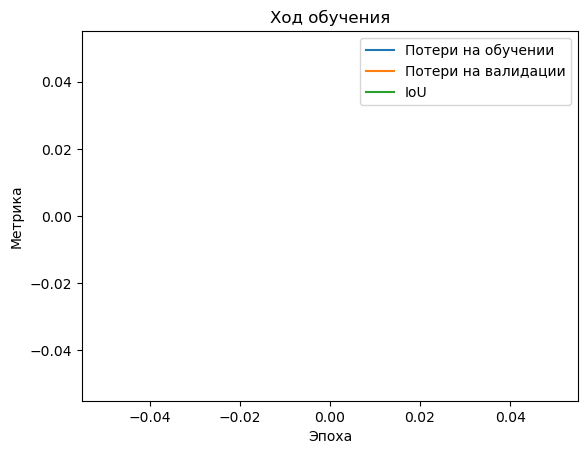

In [25]:
plt.plot([x.detach().cpu() for x in train_loss])
plt.plot([x.cpu() for x in test_loss]);
plt.plot(iou);
plt.title('Ход обучения')
plt.xlabel('Эпоха')
plt.ylabel('Метрика')
plt.legend(['Потери на обучении', 'Потери на валидации', 'IoU']);

In [26]:
model.load_state_dict(torch.load('dog-detector.pt'))

<All keys matched successfully>

In [27]:
batch = next(iter(test_dl))

/tmp/ipykernel_26882/2389736665.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 4, k+1)
/tmp/ipykernel_26882/2389736665.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 4, k+5)


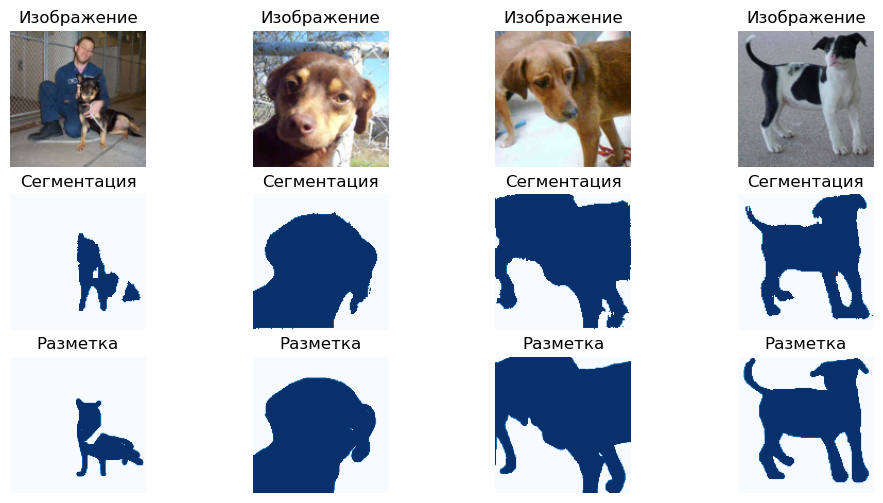

In [28]:
X, y = batch
predicted_masks = (model(X) > 0.5)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for k in range(4):
    plt.subplot(3, 4, k+1)
    plt.imshow(batch_pic(X[k]*0.5+0.5))
    plt.title('Изображение')
    plt.axis('off')
    plt.subplot(3, 4, k+5)
    plt.imshow(batch_pic(predicted_masks[k]), cmap='Blues')
    plt.title('Сегментация')
    plt.axis('off')
    plt.subplot(3, 4, k+9)
    plt.imshow(batch_pic(y[k]), cmap='Blues')
    plt.title('Разметка')
    plt.axis('off')

# Генеративно-состязательные сети

## DCGAN

In [29]:
from torchvision.datasets import LFWPeople

In [30]:
transformations = tt.Compose(
    [
        tt.Resize((128,128)),
        tt.RandomRotation(3),
        tt.RandomHorizontalFlip(p=0.5),
        tt.ToImageTensor(),
        tt.ConvertImageDtype(),
        tt.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
)

In [31]:
dataset = LFWPeople('lfw-data', split='train', transform=transformations, download=True)

Files already downloaded and verified


In [32]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=12, pin_memory=True)

In [33]:
dataloader = accelerator.prepare(dataloader)

### Критик

In [34]:
class Discriminator(nn.Module):
    def conv_block(self, in_channels, out_channels, padding=1):
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, padding=padding, padding_mode='reflect', bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.SiLU(inplace=True),
        )
        return self.conv
    def __init__(self, n_features=LATENT_SIZE):
        super().__init__()
        self.net = nn.Sequential(
            self.conv_block(3, n_features),
            self.conv_block(n_features, n_features * 2),
            self.conv_block(n_features * 2, n_features * 4),
            self.conv_block(n_features * 4, n_features * 8),
            self.conv_block(n_features * 8, n_features * 16),
            nn.Conv2d(n_features * 16, 1, kernel_size=4, stride=2, padding=0),
            #nn.Sigmoid(),
        )
    def forward(self, x):
        return self.net(x)

In [35]:
torchinfo.summary(Discriminator().to(DEVICE), (3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1, 1]                 --
├─Sequential: 1-1                        [1, 1, 1]                 --
│    └─Sequential: 2-1                   [128, 64, 64]             --
│    │    └─Conv2d: 3-1                  [128, 64, 64]             6,144
│    │    └─InstanceNorm2d: 3-2          [128, 64, 64]             --
│    │    └─SiLU: 3-3                    [128, 64, 64]             --
│    └─Sequential: 2-2                   [256, 32, 32]             --
│    │    └─Conv2d: 3-4                  [256, 32, 32]             524,288
│    │    └─InstanceNorm2d: 3-5          [256, 32, 32]             --
│    │    └─SiLU: 3-6                    [256, 32, 32]             --
│    └─Sequential: 2-3                   [512, 16, 16]             --
│    │    └─Conv2d: 3-7                  [512, 16, 16]             2,097,152
│    │    └─InstanceNorm2d: 3-8          [512, 16, 16]             --


### Генератор

In [36]:
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.epsilon = torch.finfo(torch.float32).eps
    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

In [37]:
class Generator(nn.Module):
    def upconv_block(self, in_channels, out_channels, padding=1):
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, padding=padding, bias=False),
            PixelNorm(),
            nn.SiLU(inplace=True),
        )
        return self.conv
        
    def __init__(self, latent_size=LATENT_SIZE):
        super().__init__()
        self.net = nn.Sequential(
            self.upconv_block(LATENT_SIZE, latent_size * 16, padding=0),
            self.upconv_block(latent_size * 16, latent_size * 8),
            self.upconv_block(latent_size * 8, latent_size * 4),
            self.upconv_block(latent_size * 4, latent_size * 2),
            self.upconv_block(latent_size * 2, latent_size * 1),
            nn.ConvTranspose2d(latent_size, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
        
    def forward(self, x):
        return self.net(x)

In [38]:
torchinfo.summary(Generator(), (LATENT_SIZE,1,1))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [3, 128, 128]             --
├─Sequential: 1-1                        [3, 128, 128]             --
│    └─Sequential: 2-1                   [2048, 4, 4]              --
│    │    └─ConvTranspose2d: 3-1         [2048, 4, 4]              4,194,304
│    │    └─PixelNorm: 3-2               [2048, 4, 4]              --
│    │    └─SiLU: 3-3                    [2048, 4, 4]              --
│    └─Sequential: 2-2                   [1024, 8, 8]              --
│    │    └─ConvTranspose2d: 3-4         [1024, 8, 8]              33,554,432
│    │    └─PixelNorm: 3-5               [1024, 8, 8]              --
│    │    └─SiLU: 3-6                    [1024, 8, 8]              --
│    └─Sequential: 2-3                   [512, 16, 16]             --
│    │    └─ConvTranspose2d: 3-7         [512, 16, 16]             8,388,608
│    │    └─PixelNorm: 3-8               [512, 16, 16]         

In [39]:
class DCGAN:
    def __init__(self, discriminator, generator, lr=3e-4):
        disc_optim = AdamW(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
        gen_optim = AdamW(generator.parameters(), lr=lr, betas=(0.5, 0.999))
        
        self.discriminator, self.generator, self.disc_optim, self.gen_optim = accelerator.prepare(
                                                                                                    discriminator,
                                                                                                    generator,
                                                                                                    disc_optim,
                                                                                                    gen_optim,
                                                                                                 )
        self.criterion = nn.BCEWithLogitsLoss()
        
    def train(self, epochs, data_tr):
        # Forward declaration:
        return train_gan(self, epochs, data_tr)

In [40]:
discriminator = Discriminator()
generator = Generator()

In [41]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [42]:
initialize_weights(discriminator)
initialize_weights(generator)

In [43]:
model = DCGAN(discriminator, generator)

In [44]:
picture = lambda t: (t * 0.5 + 0.5).permute(1, 2, 0).cpu().detach().numpy()

In [45]:
def train_gan(model, epochs, data_tr):
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        loss_disc = 0
        loss_gen = 0

        for source, _ in tqdm(data_tr):
            model.discriminator.train()
            model.generator.train()
            # Generating a fake image:
            fake = model.generator(torch.randn((BATCH_SIZE, LATENT_SIZE, 1, 1), device=DEVICE))
            # Test the discriminator against real and fake images:
            estimation_real = model.discriminator(source)
            estimation_fake = discriminator(fake.detach())
            real_loss = model.criterion(estimation_real, torch.ones_like(estimation_real))
            fake_loss = model.criterion(estimation_fake, torch.zeros_like(estimation_fake))
            # Average loss:    
            disc_loss = (real_loss + fake_loss) / 2.
            model.disc_optim.zero_grad()
            accelerator.backward(disc_loss)
            model.disc_optim.step()
            loss_disc += disc_loss
            
            # Test the generator:
            estimation_fake = model.discriminator(fake)
            gen_loss = model.criterion(estimation_fake, torch.ones_like(estimation_fake))
        
            model.gen_optim.zero_grad()
            accelerator.backward(gen_loss)
            model.gen_optim.step()
            loss_gen += gen_loss
            
        loss_disc /= len(data_tr)
        loss_gen /= len(data_tr)    
        print(f'Epoch {epoch}: disc loss {loss_disc}, gen loss {loss_gen:.2f}')            

        model.discriminator.eval()
        model.generator.eval()

        clear_output(wait=True)
        for k in range(5):
            plt.subplot(3, 5, k+1)
            plt.imshow(picture(source[k]))
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 5, k+6)
            plt.imshow(picture(fake[k]))
            plt.title('Output')
            plt.axis('off')
            
        plt.suptitle(f'Epoch {epoch+1}/{epochs}: disc loss {loss_disc:.2E}, gen loss {loss_gen:.2f}')
        plt.show()

    model.discriminator.eval()
    model.generator.eval()

In [46]:
#model.train(20, dataloader)

In [47]:
#torch.save(model.discriminator.state_dict(), 'dcgan-disc.pt')
#torch.save(model.generator.state_dict(), 'dcgan-gen.pt')

In [48]:
model.discriminator.load_state_dict(torch.load('dcgan-disc.pt'))
model.generator.load_state_dict(torch.load('dcgan-gen.pt'))

<All keys matched successfully>

In [49]:
n_images = BATCH_SIZE

with torch.no_grad():
    fixed_latent = torch.randn((n_images, LATENT_SIZE, 1, 1), device=DEVICE)
    fake_images = model.generator(fixed_latent)

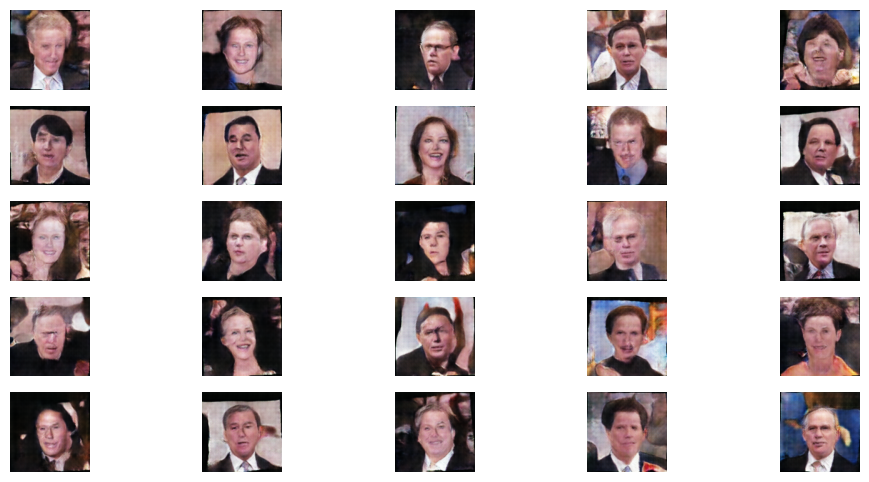

In [50]:
side = int(n_images ** 0.5)
fig, axes = plt.subplots(side, side, figsize=(12,6))
for i, ax in enumerate(axes.flat):
    ax.axis("off")
    ax.imshow(picture(fake_images[i]))

## Pix2Pix

In [51]:
IMAGE_SIZE = 256
LATENT_SIZE = 64
BATCH_SIZE = 32

In [52]:
transformations = tt.Compose(
    [
        tt.ToImageTensor(),
        tt.ConvertImageDtype(),
        tt.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
        tt.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
)

### Реализация датасета из склеенных горизонтально изображений

In [53]:
class SplitDataset(Dataset):
    def __init__(self, root, size=600):
        self.root = root
        self.size = size
        self.root = Path(root)
        self.img_list = []
        for file in (self.root).iterdir():
            if file.is_file():
                self.img_list.append(file.name)
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        filename = self.img_list[idx]
        path = Path(self.root, filename)
        image = np.array(Image.open(path))
        
        # Таргет слева:
        target = image[:, :self.size, :]
        source = image[:, self.size:, :]
        
        source = transformations(source)
        target = transformations(target)
        
        return source, target

In [54]:
train_set = SplitDataset('maps/train')
test_set = SplitDataset('maps/val')

In [55]:
train_set[0][1].shape

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


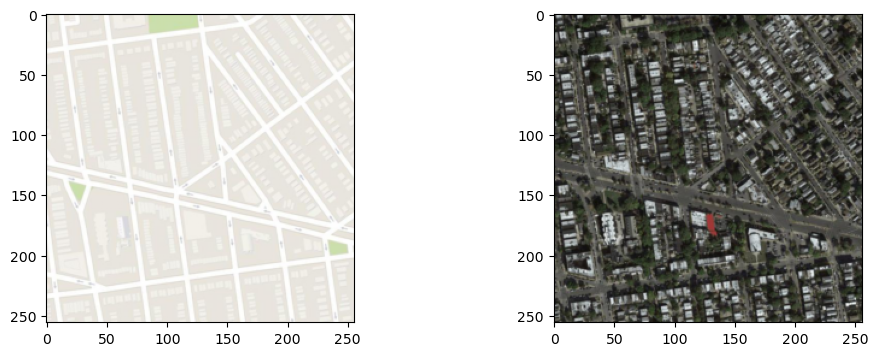

In [56]:
fig, axes = plt.subplots(1,2, figsize=(12, 4))
axes[0].imshow(picture(train_set[0][0]));
axes[1].imshow(picture(train_set[0][1]));

In [57]:
train_loader = DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=12)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=12, drop_last=True)

In [58]:
train_loader, test_loader = accelerator.prepare(train_loader, test_loader)

### Критик

In [59]:
class Discriminator(nn.Module):
    def conv_block(self, in_channels, out_channels, padding=1):
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, padding=padding, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True),
        )
        return self.conv
    def __init__(self, n_features=LATENT_SIZE):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3 * 2, n_features, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.SiLU(inplace=True),
            self.conv_block(n_features, n_features * 2),
            self.conv_block(n_features * 2, n_features * 4),
            self.conv_block(n_features * 4, n_features * 8),
            #self.conv_block(n_features * 8, n_features * 16),
            nn.Conv2d(n_features * 8, 1, kernel_size=4, stride=2, padding=0, padding_mode='reflect'),
        )
    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        return self.net(x)

### Генератор

In [60]:
class Generator(nn.Module):
    def upconv_block(self, in_channels, out_channels, down=True, act='relu'):
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, padding_mode='reflect') if down else
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True) if act=='relu' else nn.SiLU(inplace=True),
        )
        return self.conv
        
    def __init__(self, n_features=LATENT_SIZE, in_channels=3):
        super().__init__()
        # Тут не нормализуем!
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, n_features, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.Mish(inplace=True)
        )
        self.down1 = self.upconv_block(n_features, n_features*2, act='mish')
        self.down2 = self.upconv_block(n_features*2, n_features*4, act='mish')
        self.down3 = self.upconv_block(n_features*4, n_features*8, act='mish')
        self.down4 = self.upconv_block(n_features*8, n_features*8, act='mish')
        self.down5 = self.upconv_block(n_features*8, n_features*8, act='mish')
        self.down6 = self.upconv_block(n_features*8, n_features*8, act='mish')

        self.bottleneck = nn.Sequential(
            nn.Conv2d(n_features*8, n_features*8, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.ReLU(inplace=True),
        )
        
        self.up1 = self.upconv_block(n_features*8, n_features*8, down=False)
        self.up2 = self.upconv_block(n_features*16, n_features*8, down=False)
        self.up3 = self.upconv_block(n_features*16, n_features*8, down=False)
        self.up4 = self.upconv_block(n_features*16, n_features*8, down=False)
        self.up5 = self.upconv_block(n_features*16, n_features*4, down=False)
        self.up6 = self.upconv_block(n_features*8, n_features*2, down=False)
        self.up7 = self.upconv_block(n_features*4, n_features, down=False)
    
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(n_features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

        self.drop = nn.Dropout(0.5)
        
    def forward(self, x):
        initial = self.initial_down(x)
        conv1 = self.down1(initial)
        conv2 = self.down2(conv1)
        conv3 = self.down3(conv2)
        conv4 = self.down4(conv3)
        conv5 = self.down5(conv4)
        conv6 = self.down6(conv5)
        
        mid = self.bottleneck(conv6)
        
        upconv1 = self.up1(mid)
        upconv1 = self.drop(upconv1)
        upconv2 = self.up2(torch.cat([upconv1, conv6], dim=1))
        upconv2 = self.drop(upconv2)
        upconv3 = self.up3(torch.cat([upconv2, conv5], dim=1))
        upconv3 = self.drop(upconv3)
        upconv4 = self.up4(torch.cat([upconv3, conv4], dim=1))
        #upconv4 = self.drop(upconv4)
        upconv5 = self.up5(torch.cat([upconv4, conv3], dim=1))
        upconv6 = self.up6(torch.cat([upconv5, conv2], dim=1))
        upconv7 = self.up7(torch.cat([upconv6, conv1], dim=1))
        result = self.final_up(torch.cat([upconv7, initial], dim=1))
        return result

In [61]:
torchinfo.summary(Generator().to(DEVICE), (1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 256, 256]          --
├─Sequential: 1-1                        [1, 64, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         3,136
│    └─Mish: 2-2                         [1, 64, 128, 128]         --
├─Sequential: 1-2                        [1, 128, 64, 64]          --
│    └─Conv2d: 2-3                       [1, 128, 64, 64]          131,072
│    └─BatchNorm2d: 2-4                  [1, 128, 64, 64]          256
│    └─SiLU: 2-5                         [1, 128, 64, 64]          --
├─Sequential: 1-3                        [1, 256, 32, 32]          --
│    └─Conv2d: 2-6                       [1, 256, 32, 32]          524,288
│    └─BatchNorm2d: 2-7                  [1, 256, 32, 32]          512
│    └─SiLU: 2-8                         [1, 256, 32, 32]          --
├─Sequential: 1-4                        [1, 512, 16, 16]          --


In [62]:
discriminator = Discriminator()
generator = Generator()

In [63]:
initialize_weights(discriminator)
initialize_weights(generator)

In [64]:
class Pix2Pix:
    def __init__(self, discriminator, generator, lr=2e-4, ratio=1.):
        disc_optim = AdamW(discriminator.parameters(), lr=lr/ratio, betas=(0.5, 0.999))
        gen_optim = AdamW(generator.parameters(), lr=lr, betas=(0.5, 0.999))
        
        self.discriminator, self.generator, self.disc_optim, self.gen_optim = accelerator.prepare(
                                                                                                    discriminator,
                                                                                                    generator,
                                                                                                    disc_optim,
                                                                                                    gen_optim,
                                                                                                 )
        self.criterion = nn.BCEWithLogitsLoss()
        self.similarity = nn.L1Loss()
        
    def train(self, epochs, data_tr, data_val):
        # Forward declaration:
        return train_gan(self, epochs, data_tr, data_val)

In [65]:
model = Pix2Pix(discriminator, generator)

In [66]:
train_loss = []
val_loss = []

In [67]:
def train_gan(model, epochs, data_tr, data_val):
    train_loss = []
    val_loss = []
    
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        loss_disc = 0
        loss_gen = 0

        for source, target in tqdm(data_tr):
            model.discriminator.train()
            model.generator.train()
            # Generating a fake image:
            fake = model.generator(source)
            # Test the discriminator against real and fake images:
            estimation_real = model.discriminator(source, target)
            estimation_fake = discriminator(source, fake.detach())
            real_loss = model.criterion(estimation_real, torch.ones_like(estimation_real))
            fake_loss = model.criterion(estimation_fake, torch.zeros_like(estimation_fake))
            # Average loss:    
            disc_loss = (real_loss + fake_loss) / 2.
            model.disc_optim.zero_grad()
            accelerator.backward(disc_loss)
            model.disc_optim.step()
            loss_disc += disc_loss
            
            # Check the generator result against the discriminator:
            estimation_fake = model.discriminator(source, fake)
            fake_loss = model.criterion(estimation_fake, torch.ones_like(estimation_fake))
            # Check the generator result against the ground truth:
            target_loss = model.similarity(fake, target) * 100.
            # Weighted sum:
            gen_loss = fake_loss + target_loss
        
            model.gen_optim.zero_grad()
            accelerator.backward(gen_loss)
            model.gen_optim.step()
            loss_gen += gen_loss
                
        loss_disc /= len(data_tr)
        loss_gen /= len(data_tr)    
        print(f'Epoch {epoch}: disc loss {loss_disc}, gen loss {loss_gen:.2f}')
        
        train_loss.append(loss_gen.detach().cpu())
        
        # Validation:
        loss_gen = 0
        model.discriminator.eval()
        model.generator.eval()
        with torch.no_grad():
            for source, target, in tqdm(data_val):
                fake = model.generator(source)
                estimation_fake = model.discriminator(source, fake)
                fake_loss = model.criterion(estimation_fake, torch.ones_like(estimation_fake))
                target_loss = model.similarity(fake, target) * 100.
        
                gen_loss = fake_loss + target_loss
                loss_gen += gen_loss
            
        loss_gen /= len(data_val)
        val_loss.append(loss_gen.detach().cpu())

        clear_output(wait=True)
        fig, axes = plt.subplots(1, 8, figsize=(16,4));
        for k, ax in enumerate(axes.flatten()):
            ax.imshow(picture(source[k]));
            ax.axis('off');
        plt.suptitle(f'Epoch {epoch+1}/{epochs}: disc loss {loss_disc:.2f}, gen loss {loss_gen:.2f}');

        fig, axes = plt.subplots(1, 8, figsize=(16,4));
        for k, ax in enumerate(axes.flatten()):
            ax.imshow(picture(target[k]));
            ax.axis('off');
        fig, axes = plt.subplots(1, 8, figsize=(16,4));
        for k, ax in enumerate(axes.flatten()):
            ax.imshow(picture(fake[k]));
            ax.axis('off');
        plt.show()

    model.discriminator.eval()
    model.generator.eval()
    return train_loss, val_loss

In [68]:
#train_loss, val_loss = model.train(25, train_loader, test_loader)

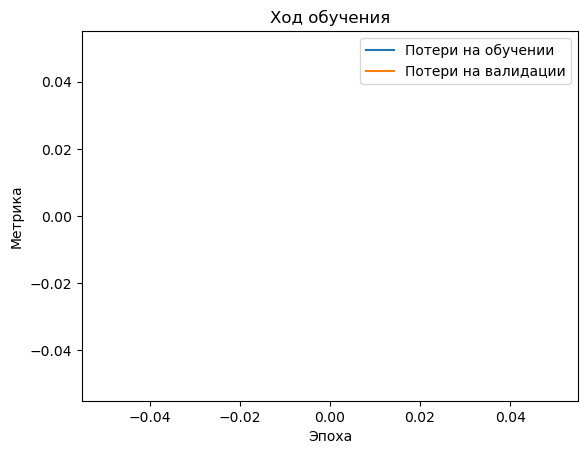

In [69]:
plt.plot(train_loss)
plt.plot(val_loss);
plt.title('Ход обучения')
plt.xlabel('Эпоха')
plt.ylabel('Метрика')
plt.legend(['Потери на обучении', 'Потери на валидации']);

In [70]:
#torch.save(model.discriminator.state_dict(), 'p2p-disc.pt')
#torch.save(model.generator.state_dict(), 'p2p-gen.pt')

In [71]:
model.discriminator.load_state_dict(torch.load('p2p-disc.pt'))
model.generator.load_state_dict(torch.load('p2p-gen.pt'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


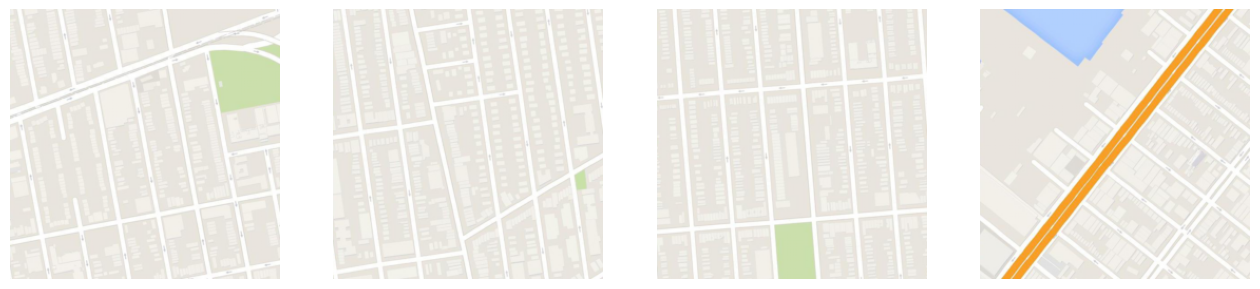

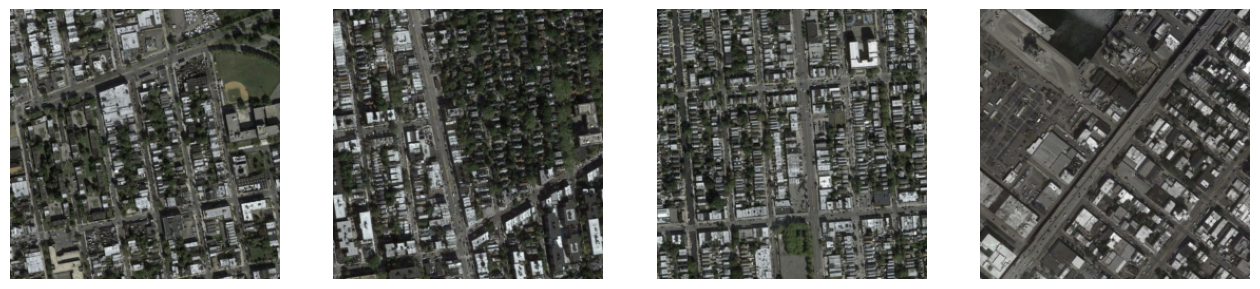

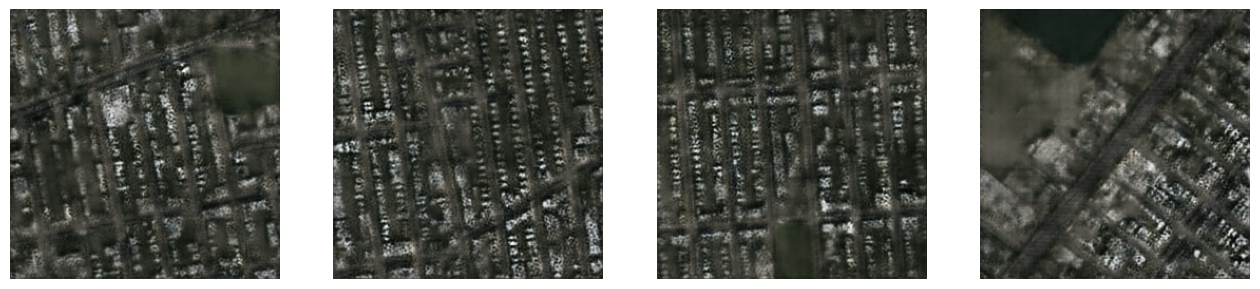

In [72]:
X, y = next(iter(test_loader))

with torch.no_grad():
    fake = model.generator(X)
    
fig, axes = plt.subplots(1, 4, figsize=(16,4));
for k, ax in enumerate(axes.flatten()):
    ax.imshow(picture(X[k]));
    ax.axis('off');
plt.show();
fig, axes = plt.subplots(1, 4, figsize=(16,4));
for k, ax in enumerate(axes.flatten()):
    ax.imshow(picture(y[k]));
    ax.axis('off');
plt.show();
fig, axes = plt.subplots(1, 4, figsize=(16,4));
for k, ax in enumerate(axes.flatten()):
    ax.imshow(picture(fake[k]));
    ax.axis('off');
plt.show();